#verify pyEMU results with the henry problem

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu

instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [2]:
la = pyemu.Schur("freyberg.jcb",verbose=False)
la.drop_prior_information()
jco_ord = la.jco.get(la.pst.obs_names,la.pst.par_names)
ord_base = "freyberg_ord"
jco_ord.to_binary(ord_base + ".jco")  
la.pst.write(ord_base+".pst")

extract and save the forecast sensitivity vectors

In [3]:
pv_names = []
predictions =  ["travel_time", "sw_gw_0","sw_gw_1","sw_gw_2"]
for pred in predictions:
    pv = jco_ord.extract(pred).T
    pv_name = pred + ".vec"
    pv.to_ascii(pv_name)
    pv_names.append(pv_name)
    

save the prior parameter covariance matrix as an uncertainty file

In [4]:
prior_uncfile = "pest.unc"
la.parcov.to_uncfile(prior_uncfile,covmat_file=None)

#PRECUNC7
write a response file to feed ```stdin``` to ```predunc7```

In [6]:
post_mat = "post.cov"
post_unc = "post.unc"
args = [ord_base + ".pst","1.0",prior_uncfile,
        post_mat,post_unc,"1"]
pd7_in = "predunc7.in"
f = open(pd7_in,'w')
f.write('\n'.join(args)+'\n')
f.close()
out = "pd7.out"
pd7 = os.path.join("exe","i64predunc7.exe")
os.system(pd7 + " <" + pd7_in + " >"+out)
for line in open(out).readlines():
    print line,


 PREDUNC7 Version 13.3. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file: 
 Enter name for posterior parameter covariance matrix file:  Enter name for posterior parameter uncertainty file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file freyberg_ord.pst....
 - file freyberg_ord.pst read ok.

 - reading Jacobian matrix file freyberg_ord.jco....
 - file freyberg_ord.jco read ok.

 - reading parameter uncertainty file pest.unc....
 - parameter uncertainty file pest.unc read ok.
 - forming XtC-1(e)X matrix....
 - inverting prior C(p) matrix....
 - inverting [XtC-1(e)X + C-1(p)] matrix....
 - writing file post.cov...
 - file post.cov written ok.
 - writing file post.unc...
 - file post.

load the posterior matrix written by ```predunc7```

In [8]:
post_pd7 = pyemu.Cov()
post_pd7.from_ascii(post_mat)

la_ord = pyemu.Schur(jco=ord_base+".jco",predictions=predictions)
post_pyemu = la_ord.posterior_parameter
#post_pyemu = post_pyemu.get(post_pd7.row_names)

The cumulative difference between the two posterior matrices:

In [9]:
delta = (post_pd7 - post_pyemu).x
(post_pd7 - post_pyemu).to_ascii("delta.cov")
print delta.sum()
print delta.max(),delta.min()

-6.64002682161e-06
4.98006134109e-08 -5.01255543739e-08


#PREDUNC1
write a response file to feed ```stdin```.  Then run ```predunc1``` for each forecast

In [10]:
args = [ord_base + ".pst", "1.0", prior_uncfile, None, "1"]
pd1_in = "predunc1.in"
pd1 = os.path.join("exe", "i64predunc1.exe")
pd1_results = {}
for pv_name in pv_names:
    args[3] = pv_name
    f = open(pd1_in, 'w')
    f.write('\n'.join(args) + '\n')
    f.close()
    out = "predunc1" + pv_name + ".out"
    os.system(pd1 + " <" + pd1_in + ">" + out)
    f = open(out,'r')
    for line in f:
        if "pre-cal " in line.lower():
            pre_cal = float(line.strip().split()[-2])
        elif "post-cal " in line.lower():
            post_cal = float(line.strip().split()[-2])
    f.close()        
    pd1_results[pv_name.split('.')[0].lower()] = [pre_cal, post_cal]  
   
  

organize the ```pyemu``` results into a structure for comparison

In [11]:
pyemu_results = {}
for pname in la_ord.prior_prediction.keys():
    pyemu_results[pname] = [np.sqrt(la_ord.prior_prediction[pname]),
                            np.sqrt(la_ord.posterior_prediction[pname])]

compare the results:

In [12]:
f = open("predunc1_textable.dat",'w')
for pname in pd1_results.keys():
    print pname
    f.write(pname+"&{0:6.5f}&{1:6.5}&{2:6.5f}&{3:6.5f}\\\n"\
            .format(pd1_results[pname][0],pyemu_results[pname][0],
                    pd1_results[pname][1],pyemu_results[pname][1]))
    print "prior",pname,pd1_results[pname][0],pyemu_results[pname][0]
    print "post",pname,pd1_results[pname][1],pyemu_results[pname][1]
f.close()

sw_gw_1
prior sw_gw_1 788.1179 788.117930411
post sw_gw_1 787.6817 787.681800039
sw_gw_0
prior sw_gw_0 282.195 282.195029354
post sw_gw_0 212.7603 212.760315313
travel_time
prior travel_time 6096.554 6096.55451954
post travel_time 5778.424 5778.42430856
sw_gw_2
prior sw_gw_2 814.2057 814.205751254
post sw_gw_2 814.0056 814.005679926


##PREDVAR1b
write the nessecary files to run ```predvar1b```

In [18]:
f = open("pred_list.dat",'w')
out_files = []
for pv in pv_names:
    out_name = pv+".predvar1b.out"
    out_files.append(out_name)
    f.write(pv+" "+out_name+"\n")
f.close()
args = [ord_base+".pst","1.0","pest.unc","pred_list.dat"]
for i in xrange(36):
    args.append(str(i))
args.append('')    
args.append("n")
args.append("n")
args.append("y")
args.append("n")
args.append("n")
f = open("predvar1b.in", 'w')
f.write('\n'.join(args) + '\n')
f.close()

os.system("exe\\predvar1b.exe <predvar1b.in")


0

In [19]:
pv1b_results = {}
for out_file in out_files:
    pred_name = out_file.split('.')[0]
    f = open(out_file,'r')
    for _ in xrange(3):
        f.readline()
    arr = np.loadtxt(f)
    pv1b_results[pred_name] = arr


now for pyemu

In [22]:
omitted_parameters = [pname for pname in la.pst.parameter_data.parnme if pname.startswith("wf")]
la_ord_errvar = pyemu.ErrVar(jco=ord_base+".jco",
                             predictions=predictions,
                             omitted_parameters=omitted_parameters,
                             verbose=False)
df = la_ord_errvar.get_errvar_dataframe(np.arange(36))
df

first                                                   \
          sw_gw_0         sw_gw_1         sw_gw_2      travel_time   
0    77533.592215   528441.245961   564572.594781  36929891.310551   
1   108687.070550   528675.175679   564572.307985  36927525.501721   
2   106758.010109   528670.674069   564543.322334  36727912.768256   
3   105651.239320   528644.229942   564525.872312  36693082.951657   
4   102618.177636   528642.555795   564454.907167  36586341.589001   
5   102247.584169   528501.494334   564353.642378  36412997.266778   
6   100763.341086   528496.335777   564316.966679  35502258.332400   
7    99459.069459   528472.170944   564316.284131  35327202.671613   
8    89775.718975   528268.280298   564293.112671  35287003.483926   
9    89258.742133   528259.236880   564290.759611  34946775.814210   
10   89180.821764   528258.871542   564290.711843  34920521.834892   
11   88235.124799   528248.133869   564289.820695  33708775.253444   
12   87472.153964   528237.286876   564288.651832  33685915.435696   
13   85218.917993   528209.164989   564285.828329  33628646.025618   
14   85217.528885  1267225.825940  1522867.861020  38427960.268667   
15   85217.512010  1415053.413652  1714555.723111  39329258.823732   
16   85217.434586  1967662.193264  2431582.674827  44163457.488756   
17   85216.768234  1701728.496657  2087072.841679  42677376.678632   
18   85216.707138  1701727.386452  2087069.981752  42669974.845914   
19   85215.907173  1599564.577073  1954345.929974  41945510.733145   
20   85215.715729  1559144.465941  1901715.285691  41764416.200476   
21   85214.684434  1149500.832909  1370328.472687  37901765.544565   
22   85214.207555  1145484.543872  1365189.891053  37869577.661243   
23   85214.209763   516577.586715   548711.029035  34019976.337826   
24   85213.262934   493490.402416   518687.868815  33714332.869928   
25   85213.239460   439405.503606   448648.054526  33209934.415948   
26   85212.626700   426645.459591   432134.974564  33071744.268418   
27   85212.137334   426201.331342   431566.769320  33053345.206984   
28   85210.854565   406634.701923   406367.514472  32866770.007817   
29   85210.579193   389431.631009   383963.640299  32473491.084985   
30   85210.577098   364097.631321   351121.690825  32361840.569625   
31   85209.744859   342373.079298   323056.777460  32136429.307380   
32   85207.784695   336790.124076   315880.265998  32097938.415208   
33   85206.408219   291465.344592   256828.111608  31861067.281037   
34   85204.763510   279891.282143   241924.134094  31770658.212181   
35   85202.504792   278295.765802   239797.341285  31770667.362526   

          second                                                   third  \
         sw_gw_0       sw_gw_1       sw_gw_2   travel_time       sw_gw_0   
0   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.100442e+03   
1   1.377404e+01  1.524245e-01  5.327729e-08  4.148844e-04  1.677261e+03   
2   1.408484e+01  1.531363e-01  4.636448e-03  3.192489e+01  1.680548e+03   
3   1.437952e+01  1.601675e-01  9.267344e-03  4.117643e+01  1.694023e+03   
4   1.597257e+01  1.610202e-01  4.629325e-02  9.679402e+01  1.648795e+03   
5   1.621398e+01  2.526565e-01  1.120514e-01  2.093822e+02  1.636578e+03   
6   1.729784e+01  2.563579e-01  1.386344e-01  8.698519e+02  1.628148e+03   
7   1.838852e+01  2.765489e-01  1.392063e-01  1.015796e+03  1.593966e+03   
8   3.061537e+01  5.337179e-01  1.684253e-01  1.066004e+03  1.447574e+03   
9   3.135681e+01  5.466774e-01  1.717931e-01  1.551754e+03  1.464004e+03   
10  3.150010e+01  5.473506e-01  1.718810e-01  1.599883e+03  1.462272e+03   
11  3.332549e+01  5.680754e-01  1.736014e-01  3.930724e+03  1.432505e+03   
12  3.540222e+01  5.975862e-01  1.767807e-01  3.992548e+03  1.377585e+03   
13  4.314313e+01  6.941755e-01  1.864773e-01  4.189063e+03  1.249929e+03   
14  1.000000e+35  1.000000e+35  1.000000e+35  1.000000e+35  1.000000e+35   
15  1.000000e+35  1.000000e+35  1.000000e+35  1.000000e+35 

generate some plots to verify

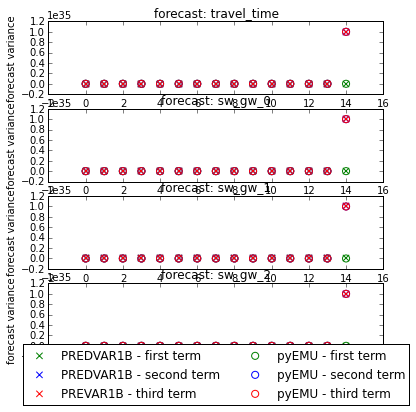

In [23]:
fig = plt.figure(figsize=(6,6))
max_idx = 15
idx = np.arange(max_idx)
for ipred,pred in enumerate(predictions):
    arr = pv1b_results[pred][:max_idx,:]
    first = df[("first", pred)][:max_idx]
    second = df[("second", pred)][:max_idx]
    third = df[("third", pred)][:max_idx]
    ax = plt.subplot(len(predictions),1,ipred+1)
    #ax.plot(arr[:,1],color='b',dashes=(6,6),lw=4,alpha=0.5)
    #ax.plot(first,color='b')
    #ax.plot(arr[:,2],color='g',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(second,color='g')
    #ax.plot(arr[:,3],color='r',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(third,color='r')
    
    ax.scatter(idx,arr[:,1],marker='x',s=40,color='g',
               label="PREDVAR1B - first term")
    ax.scatter(idx,arr[:,2],marker='x',s=40,color='b',
               label="PREDVAR1B - second term")
    ax.scatter(idx,arr[:,3],marker='x',s=40,color='r',
               label="PREVAR1B - third term")
    ax.scatter(idx,first,marker='o',facecolor='none',
               s=50,color='g',label='pyEMU - first term')
   
    ax.scatter(idx,second,marker='o',facecolor='none',
               s=50,color='b',label="pyEMU - second term")
    
    ax.scatter(idx,third,marker='o',facecolor='none',
               s=50,color='r',label="pyEMU - third term")
    ax.set_ylabel("forecast variance")
    ax.set_title("forecast: " + pred)
    if ipred == len(predictions) -1:
        ax.legend(loc="lower center",bbox_to_anchor=(0.5,-0.75),
                  scatterpoints=1,ncol=2)
        ax.set_xlabel("singular values")
    #break
plt.savefig("predvar1b_ver.eps")    
    

#Identifiability

In [24]:
cmd_args = [os.path.join("exe","i64identpar.exe"),ord_base,"5",
            "null","null","ident.out","/s"]
cmd_line = ' '.join(cmd_args)+'\n'
print(cmd_line)
print(os.getcwd())
os.system(cmd_line)

exe\i64identpar.exe freyberg_ord 5 null null ident.out /s

D:\Home\git\pyemu\verification\Freyberg


0

In [25]:
identpar_df = pd.read_csv("ident.out",delim_whitespace=True)

In [28]:
la_ord_errvar = pyemu.ErrVar(jco=ord_base+".jco",
                             predictions=predictions,
                             verbose=False)
df = la_ord_errvar.get_identifiability_dataframe(5)
df

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,ident
rch_1,9.955541e-01,7.052885e-04,1.590869e-04,1.422682e-04,9.111534e-06,9.965699e-01
rch_2,0.000000e+00,3.081488e-33,6.240013e-32,4.437343e-31,4.930381e-32,5.585197e-31
rcond00,1.773061e-09,2.743063e-07,1.998841e-06,1.088365e-06,4.402964e-07,3.803581e-06
rcond01,4.584440e-09,6.548507e-07,4.284359e-06,2.287944e-06,8.918623e-07,8.123601e-06
rcond02,4.584440e-09,6.548507e-07,4.284359e-06,2.287944e-06,8.918623e-07,8.123601e-06
rcond03,9.277334e-09,1.267948e-06,7.720672e-06,3.952089e-06,1.396724e-06,1.434671e-05
rcond04,8.516417e-09,1.209669e-06,7.811702e-06,4.083723e-06,1.513522e-06,1.462713e-05
rcond05,4.054379e-09,6.131614e-07,4.352238e-06,2.388358e-06,9.856649e-07,8.343477e-06
rcond06,1.773061e-09,2.743063e-07,1.998841e-06,1.088365e-06,4.402964e-07,3.803581e-06
rcond07,1.627707e-11,6.855104e-10,2.667497e-10,1.078215e-09,2.344690e-09,4.391442e-09


cheap plot to verify

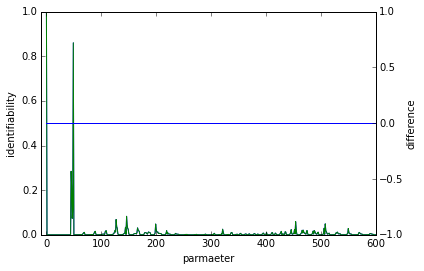

In [29]:
fig = plt.figure()
ax = plt.subplot(111)
axt = plt.twinx()
ax.plot(identpar_df["identifiability"])
ax.plot(df["ident"])
ax.set_xlim(-10,600)
diff = identpar_df["identifiability"].values - df["ident"].values
#print(diff)
axt.plot(diff)
axt.set_ylim(-1,1)
ax.set_xlabel("parmaeter")
ax.set_ylabel("identifiability")
axt.set_ylabel("difference")